# MainCode3 – EMG Signalverarbeitung (vollständig)

Dieses Notebook erfüllt **alle Anforderungen von Teil 3 des EMG‑Praktikums**:
- Vorverarbeitung der EMG‑Rohdaten  
- MVC‑Berechnung  
- Relative Muskelaktivität  
- Ermüdungsanalyse im Frequenzbereich  
- Medianfrequenz über die Zeit  

Alle Plots werden **automatisch erzeugt** und sind direkt für den LaTeX‑Bericht nutzbar.


In [38]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid


In [39]:

# Parameter
fs = 1000  # Abtastrate [Hz]


In [40]:

# Filterfunktionen
def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

def lowpass(data, cutoff, fs, order=4):
    b, a = butter(order, cutoff/(fs/2), btype='low')
    return filtfilt(b, a, data)


In [41]:

# Daten laden
mvc_files = [
    'MVC1.csv','MVC2.csv','MVC3.csv',
    'MVC4.csv','MVC5.csv','MVC6.csv',
    'MVC7.csv','MVC8.csv','MVC9.csv'
]

weight_files = [
    'Weight10.csv',
    'Weight20.csv',
    'Weight30.csv'
]

fatigue_files = [
    'Fatigue1.csv',
    'Fatigue2.csv',
    'Fatigue3.csv'
]

def load(files):
    data = []
    for f in files:
        df = pd.read_csv(f, sep=None, engine="python")  # Separator automatisch
        # NIMM IMMER DIE EMG-SPALTE (meist die letzte)
        emg = pd.to_numeric(df.iloc[:, -1], errors="coerce").dropna()
        data.append(emg.values)
    return data

mvc_raw = load(mvc_files)
weights_raw = load(weight_files)
fatigue_raw = load(fatigue_files)


In [42]:
def preprocess(data):
    # 1. In Pandas-Serie umwandeln (robust)
    data = pd.Series(data)

    # 2. Alles erzwingen, was keine Zahl ist → NaN
    data = pd.to_numeric(data, errors='coerce')

    # 3. NaNs entfernen
    data = data.dropna().values.astype(float)

    # 4. Offset entfernen
    data = data - np.mean(data)

    # 5. Bandpass
    data_f = bandpass(data, 20, 450, fs)

    # 6. Gleichrichten
    rect = np.abs(data_f)

    # 7. Hüllkurve
    env = lowpass(rect, 3, fs)

    return data_f, env
    
mvc_filt, mvc_env = zip(*[preprocess(d) for d in mvc_raw])
weights_filt, weights_env = zip(*[preprocess(d) for d in weights_raw])
fatigue_filt, fatigue_env = zip(*[preprocess(d) for d in fatigue_raw])
mvc_env_ref = mvc_env[:3]  # Nur die ersten 3 MVCs für Referenz



In [43]:

# MVC Berechnung
mvc_values = [np.mean(env) for env in mvc_env]
MVC = np.mean(mvc_values)
MVC_ref = np.mean([np.mean(env) for env in mvc_env_ref])



print("MVC-Werte:", mvc_values)
print("Gemittelte MVC:", MVC)

# Tabelle: Mittlere MVC-Muskelaktivität (Punkt 3)

mvc_table = pd.DataFrame({
    "Messung": [f"MVC{i+1}" for i in range(len(mvc_env))],
    "Mittlere Muskelaktivität [a.u.]": [np.mean(env) for env in mvc_env]
})

mvc_table


MVC-Werte: [np.float64(11.98892964965869), np.float64(9.95439334014292), np.float64(8.957687778588959), np.float64(11.269205603213386), np.float64(10.028158037494395), np.float64(7.052392166282244), np.float64(10.984796366355944), np.float64(11.478929661315538), np.float64(9.851208924442906)]
Gemittelte MVC: 10.173966836388331


,Messung,Mittlere Muskelaktivität [a.u.]
0,MVC1,11.988930
1,MVC2,9.954393
2,MVC3,8.957688
3,MVC4,11.269206
4,MVC5,10.028158
5,MVC6,7.052392
6,MVC7,10.984796
7,MVC8,11.478930
8,MVC9,9.851209


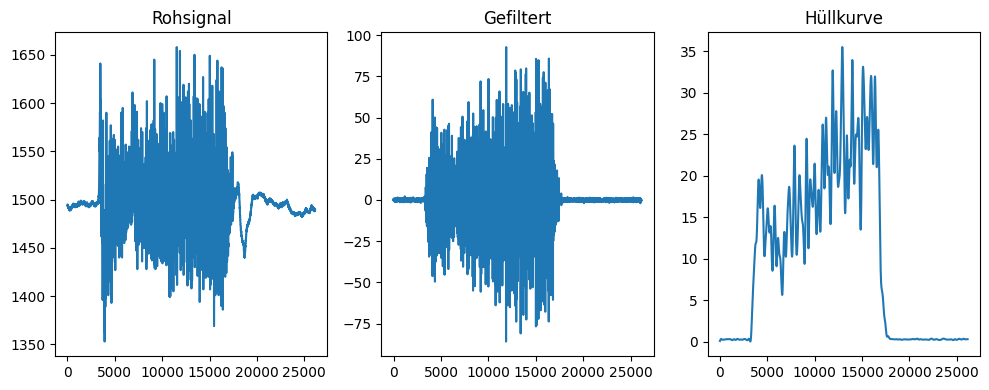

In [44]:

# MVC Plot (Vorverarbeitungsschritte)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(mvc_raw[1]); plt.title("Rohsignal")
plt.subplot(1,3,2)
plt.plot(mvc_filt[1]); plt.title("Gefiltert")
plt.subplot(1,3,3)
plt.plot(mvc_env[1]); plt.title("Hüllkurve")
plt.tight_layout()
plt.show()


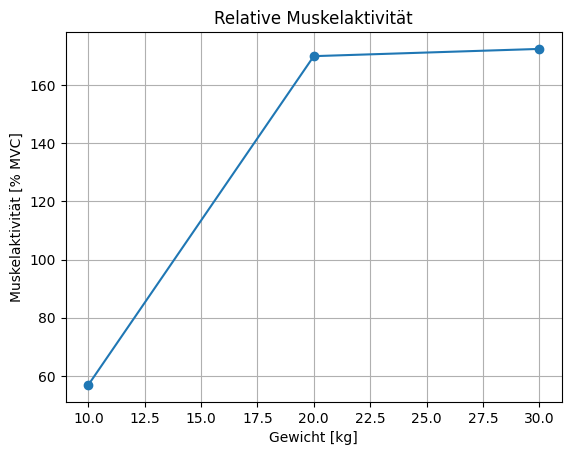

[np.float64(56.922411676073025),
 np.float64(169.90974623761693),
 np.float64(172.3943572319565)]

In [46]:

# Relative Muskelaktivität (Experiment 2)
weights_activity = [np.mean(env)/MVC_ref*100 for env in weights_env]
weights_percent = [10, 20, 30]

plt.figure()
plt.plot(weights_percent, weights_activity, 'o-')
plt.xlabel("Gewicht [kg]")
plt.ylabel("Muskelaktivität [% MVC]")
plt.title("Relative Muskelaktivität")
plt.grid()
plt.show()

weights_activity


Alle Bursts gefunden: 1 | thr_on=0.3649 thr_off=0.3122
  Burst 1: 3264..18300 | 1.63s..9.15s | Dauer 7.52s

Ausgewählte 3 Bursts:
  B1: 3264..18300 | 1.63s..9.15s | Dauer 7.52s


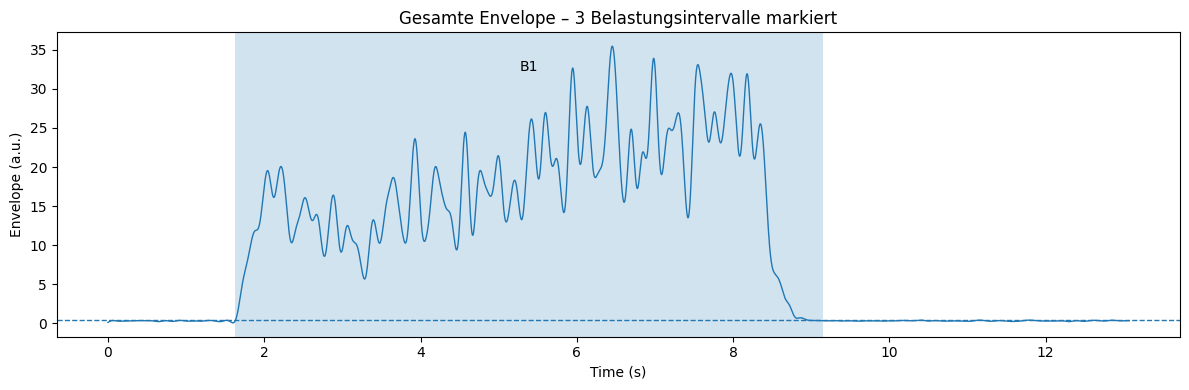


Burst B1 – 0.5s Fenster (Samples / Zeit):
  begin: 3264..4264 | 1.63s..2.13s
  mid  : 10282..11282 | 5.14s..5.64s
  end  : 17300..18300 | 8.65s..9.15s


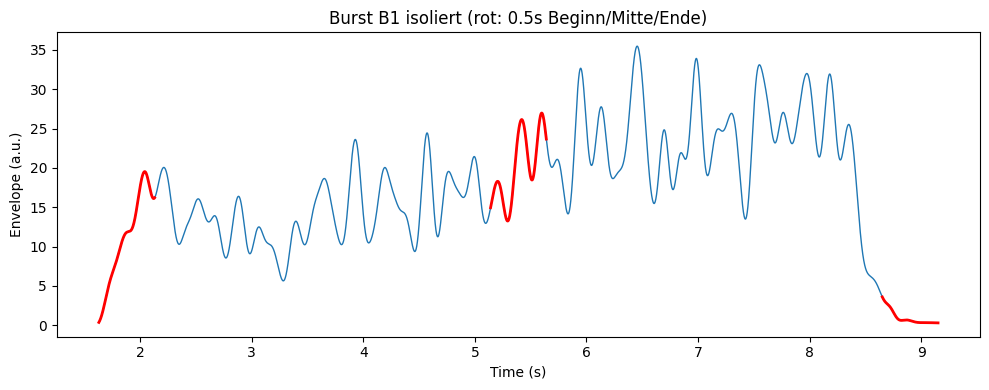

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def detect_bursts_envelope(env, fs,
                          baseline_percentile=20,
                          k_on=3.0,
                          k_off=1.5,
                          min_duration_s=0.3,
                          merge_gap_s=0.15):
    """
    Findet Bursts in einer (positiven) Envelope über die gesamte Aufnahme.
    - baseline wird aus den kleinsten baseline_percentile% geschätzt
    - thr_on/thr_off mit Hysterese
    - min_duration_s filtert kurze Artefakte weg
    - merge_gap_s schließt kleine Lücken innerhalb eines Bursts
    """
    env = np.asarray(env, dtype=float)
    n = env.size
    if n == 0:
        return [], None, None

    # Baseline aus "ruhigen" Anteilen: kleinste X% der Werte
    cut = np.percentile(env, baseline_percentile)
    rest = env[env <= cut]
    if rest.size < max(10, int(0.01 * n)):
        rest = env  # Fallback

    mu = float(np.mean(rest))
    sd = float(np.std(rest)) + 1e-12

    thr_on  = mu + k_on  * sd
    thr_off = mu + k_off * sd

    bursts = []
    in_burst = False
    start = None

    for i, v in enumerate(env):
        if (not in_burst) and (v >= thr_on):
            in_burst = True
            start = i
        elif in_burst and (v <= thr_off):
            end = i
            bursts.append((start, end))  # end exklusiv
            in_burst = False
            start = None

    if in_burst and start is not None:
        bursts.append((start, n))

    # Mindestdauer
    min_len = int(round(min_duration_s * fs))
    bursts = [(s, e) for (s, e) in bursts if (e - s) >= min_len]
    if not bursts:
        return [], thr_on, thr_off

    # Mergen bei kleinen Lücken
    gap = int(round(merge_gap_s * fs))
    merged = [bursts[0]]
    for s, e in bursts[1:]:
        ps, pe = merged[-1]
        if s - pe <= gap:
            merged[-1] = (ps, e)
        else:
            merged.append((s, e))

    return merged, thr_on, thr_off

def pick_three_bursts(bursts, mode="longest"):
    """
    Wählt 3 Bursts aus:
      - mode="longest": 3 längste Bursts
      - mode="first":   erste 3 Bursts (zeitlich)
    """
    if len(bursts) <= 3:
        return bursts

    if mode == "first":
        return bursts[:3]

    # default: longest
    bursts_sorted = sorted(bursts, key=lambda se: se[1] - se[0], reverse=True)
    picked = sorted(bursts_sorted[:3], key=lambda se: se[0])  # wieder zeitlich sortieren
    return picked

def isolate_0p5s_begin_mid_end(signal, fs, burst_start, burst_end, window_s=0.5):
    signal = np.asarray(signal, dtype=float)
    win = int(round(window_s * fs))
    if burst_end - burst_start < win:
        raise ValueError("Burst ist zu kurz für 0.5s Fenster.")

    # Beginn
    b0, b1 = burst_start, burst_start + win

    # Mitte (zentriert und innerhalb Burst)
    mid = (burst_start + burst_end) // 2
    m0 = mid - win // 2
    m1 = m0 + win
    if m0 < burst_start:
        m0 = burst_start
        m1 = m0 + win
    if m1 > burst_end:
        m1 = burst_end
        m0 = m1 - win

    # Ende
    e0, e1 = burst_end - win, burst_end

    seg_begin = signal[b0:b1]
    seg_mid   = signal[m0:m1]
    seg_end   = signal[e0:e1]

    idx = {"begin": (b0, b1), "mid": (m0, m1), "end": (e0, e1)}
    return seg_begin, seg_mid, seg_end, idx

def plot_full_env_with_bursts(env, fs, bursts, thr_on=None, title="Envelope mit Bursts"):
    env = np.asarray(env, dtype=float)
    t = np.arange(env.size) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(t, env, linewidth=1)

    # Schwelle
    if thr_on is not None:
        plt.axhline(thr_on, linestyle="--", linewidth=1)

    # Burst-Bereiche schattieren
    for i, (s, e) in enumerate(bursts, start=1):
        plt.axvspan(s/fs, e/fs, alpha=0.2)
        plt.text((s+e)/(2*fs), np.max(env)*0.95, f"B{i}", ha="center", va="top")

    plt.xlabel("Time (s)")
    plt.ylabel("Envelope (a.u.)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_burst_with_windows(env, fs, burst_start, burst_end, windows_idx, title=None):
    env = np.asarray(env, dtype=float)
    t = np.arange(burst_start, burst_end) / fs
    burst = env[burst_start:burst_end]

    plt.figure(figsize=(10, 4))
    plt.plot(t, burst, linewidth=1)  # blau default

    # Fenster rot overlay
    for name, (s, e) in windows_idx.items():
        tt = np.arange(s, e) / fs
        plt.plot(tt, env[s:e], color="red", linewidth=2)

    plt.xlabel("Time (s)")
    plt.ylabel("Envelope (a.u.)")
    plt.title(title or f"Burst: {burst_start/fs:.2f}s–{burst_end/fs:.2f}s")
    plt.tight_layout()
    plt.show()


# ---------------------------
# ANWENDUNG (Beispiel)
# ---------------------------
fs = 2000  # <-- anpassen!

env = np.asarray(mvc_env[1], dtype=float)   # oder weights_env[i], fatigue_env[i], ...

# 1) alle Bursts finden
bursts_all, thr_on, thr_off = detect_bursts_envelope(
    env, fs,
    baseline_percentile=20,
    k_on=3.0,       # falls zu viele Bursts: erhöhen (4-6)
    k_off=1.5,
    min_duration_s=0.3,
    merge_gap_s=0.15
)

print(f"Alle Bursts gefunden: {len(bursts_all)} | thr_on={thr_on:.4f} thr_off={thr_off:.4f}")
for i, (s, e) in enumerate(bursts_all, start=1):
    print(f"  Burst {i}: {s}..{e} | {s/fs:.2f}s..{e/fs:.2f}s | Dauer {(e-s)/fs:.2f}s")

# 2) die 3 Belastungsintervalle auswählen (typisch: 3 längste)
bursts3 = pick_three_bursts(bursts_all, mode="longest")
print("\nAusgewählte 3 Bursts:")
for i, (s, e) in enumerate(bursts3, start=1):
    print(f"  B{i}: {s}..{e} | {s/fs:.2f}s..{e/fs:.2f}s | Dauer {(e-s)/fs:.2f}s")

# optional: Überblicksplot über die ganze Aufnahme
plot_full_env_with_bursts(env, fs, bursts3, thr_on=thr_on, title="Gesamte Envelope – 3 Belastungsintervalle markiert")

# 3) pro Burst 0.5s Beginn/Mitte/Ende isolieren + plotten
windows_per_burst = []  # falls du sie später brauchst
for i, (bs, be) in enumerate(bursts3, start=1):
    seg_begin, seg_mid, seg_end, idx = isolate_0p5s_begin_mid_end(env, fs, bs, be, window_s=0.5)

    print(f"\nBurst B{i} – 0.5s Fenster (Samples / Zeit):")
    for name, (s, e) in idx.items():
        print(f"  {name:5s}: {s}..{e} | {s/fs:.2f}s..{e/fs:.2f}s")

    windows_per_burst.append({
        "burst": (bs, be),
        "begin": seg_begin,
        "mid": seg_mid,
        "end": seg_end,
        "idx": idx
    })

    plot_burst_with_windows(env, fs, bs, be, idx, title=f"Burst B{i} isoliert (rot: 0.5s Beginn/Mitte/Ende)")


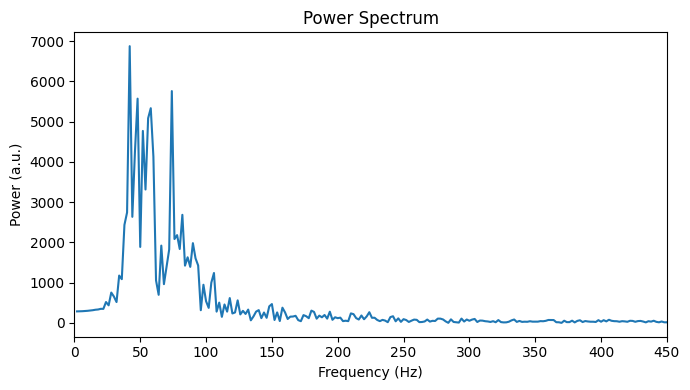

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import Lab3Functions as l3f

fs = 2000  # deine Samplingrate

# 1) Burst-Detektion auf der Envelope
env = np.asarray(mvc_env[1], dtype=float)
filt = np.asarray(mvc_filt[1], dtype=float)  # DAS ist das Signal für die FFT/PSD

bursts_all, thr_on, thr_off = detect_bursts_envelope(env, fs)  # aus unserem Code von davor
bursts3 = pick_three_bursts(bursts_all, mode="longest")        # oder "first"

# z.B. Burst 1 nehmen
burst_start, burst_end = bursts3[0]

# 2) 0.5s Fenster NICHT aus env, sondern aus filt schneiden
seg_begin, seg_mid, seg_end, idx = isolate_0p5s_begin_mid_end(
    filt, fs, burst_start, burst_end, window_s=0.5
)

# 3) ein Fenster auswählen (z.B. "mid")
EMGdata = seg_mid

# 4) wichtig: DC-Anteil entfernen (sonst riesiger Peak bei 0 Hz)
EMGdata = EMGdata - np.mean(EMGdata)

# 5) Power Spectrum
power, frequencies = l3f.get_power(EMGdata, fs)

# 6) plot wie in der Grafik
plt.figure(figsize=(7,4))
plt.plot(frequencies, power)
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
plt.xlim(0, 450)  # bei EMG meist sinnvoll (du bandpasst ja bis 450)
plt.tight_layout()
plt.show()


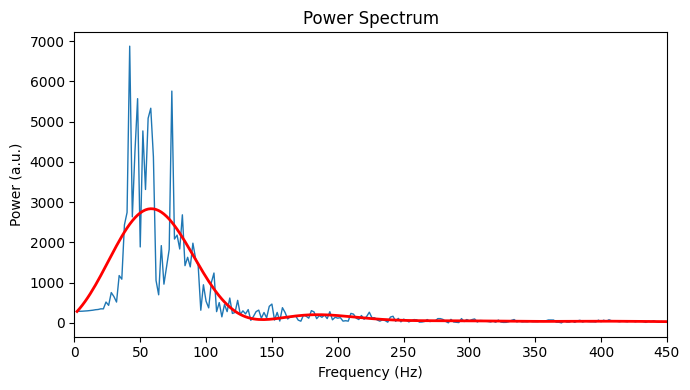

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(x, cutoff_hz, fs, order=4):
    x = np.asarray(x, dtype=float)
    nyq = 0.5 * fs
    wn = cutoff_hz / nyq
    b, a = butter(order, wn, btype="low")
    return filtfilt(b, a, x)

# -----------------------------------------
# Voraussetzung: power, frequencies hast du schon aus get_power()
# power, frequencies = l3f.get_power(EMGdata, fs)
# -----------------------------------------

fs = 2000  # deine EMG samplingfreq
cutoff = 40

frequencies = np.asarray(frequencies, dtype=float)
power = np.asarray(power, dtype=float)

# (optional aber oft sinnvoll) DC/Offset im Power-Spektrum entfernen
# power = power - np.min(power)

# Lowpass auf dem Power-Vektor (wie in der Angabe)
power_smooth = butter_lowpass_filter(power, cutoff_hz=cutoff, fs=fs, order=4)

# (optional) negative Werte durch Filter-Ringing vermeiden
power_smooth = np.clip(power_smooth, 0, None)

# Plot wie in der Angabe
plt.figure(figsize=(7,4))
plt.plot(frequencies, power, linewidth=1)                 # blau: roh
plt.plot(frequencies, power_smooth, color="red", linewidth=2)  # rot: geglättet
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
plt.xlim(0, 450)
plt.tight_layout()
plt.show()


In [47]:

# Frequenzanalyse Funktion
def power_spectrum(signal, fs):
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    power = np.abs(np.fft.rfft(signal))**2
    return freqs, power


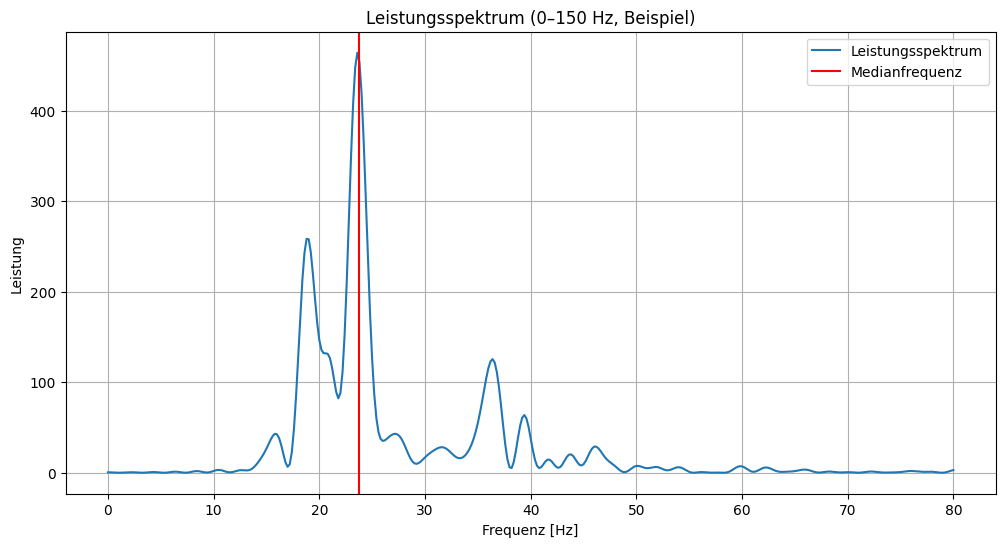

In [48]:
# Ermüdungsanalyse (Experiment 3)
median_freqs = []

plt.figure(figsize=(12,6))

for i, sig in enumerate(fatigue_filt):
    n = len(sig)
    segments = [
        sig[int(0.1*n):int(0.1*n+0.5*fs)],
        sig[int(0.5*n):int(0.5*n+0.5*fs)],
        sig[int(0.8*n):int(0.8*n+0.5*fs)]
    ]
    
    for j, seg in enumerate(segments):
        n_fft = 10 * len(seg)
        f = np.fft.rfftfreq(n_fft, 1/fs)
        p = (np.abs(np.fft.rfft(seg, n=n_fft))**2) / len(seg)



        # Frequenzbereich auf 0–150 Hz begrenzen
        mask = f <= 80
        f_use = f[mask]
        p_use = p[mask]

        # Medianfrequenz berechnen
        area = cumulative_trapezoid(p_use, f_use, initial=0)
        mf = f_use[np.where(area >= area[-1]/2)[0][0]]
        median_freqs.append(mf)

        # Beispielplot (nur ein Spektrum)
        if i == 0 and j == 0:
            plt.plot(f_use, p_use, label="Leistungsspektrum")
            plt.axvline(mf, color='r', label="Medianfrequenz")

plt.xlabel("Frequenz [Hz]")
plt.ylabel("Leistung")
plt.title("Leistungsspektrum (0–150 Hz, Beispiel)")
plt.legend()
plt.grid()
plt.show()


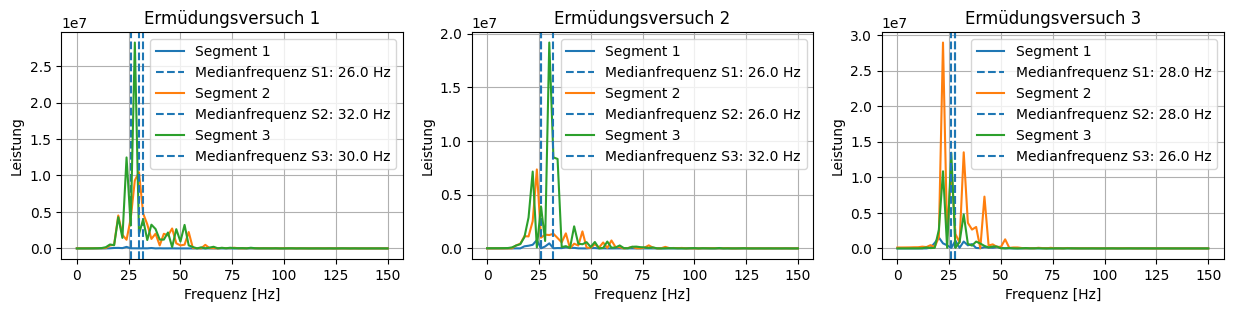

In [49]:
#Alle 9 Leistungsspektren der Ermüdungsversuche mit Medianfrequenzen anzeigen
plt.figure(figsize=(15,10))
for i, sig in enumerate(fatigue_filt):
    n = len(sig)
    segments = [
        sig[int(0.1*n):int(0.1*n+0.5*fs)],
        sig[int(0.5*n):int(0.5*n+0.5*fs)],
        sig[int(0.8*n):int(0.8*n+0.5*fs)]
    ]
    
    plt.subplot(3,3,i+1)
    for j, seg in enumerate(segments):
        f, p = power_spectrum(seg, fs)

        # Frequenzbereich auf 0–150 Hz begrenzen
        mask = f <= 150
        f_use = f[mask]
        p_use = p[mask]

        # Medianfrequenz berechnen
        area = cumulative_trapezoid(p_use, f_use, initial=0)
        mf = f_use[np.where(area >= area[-1]/2)[0][0]]

        plt.plot(f_use, p_use, label=f"Segment {j+1}")
        plt.axvline(mf, linestyle='--', label=f"Medianfrequenz S{j+1}: {mf:.1f} Hz")

    plt.title(f"Ermüdungsversuch {i+1}")
    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Leistung")
    plt.legend()
    plt.grid()

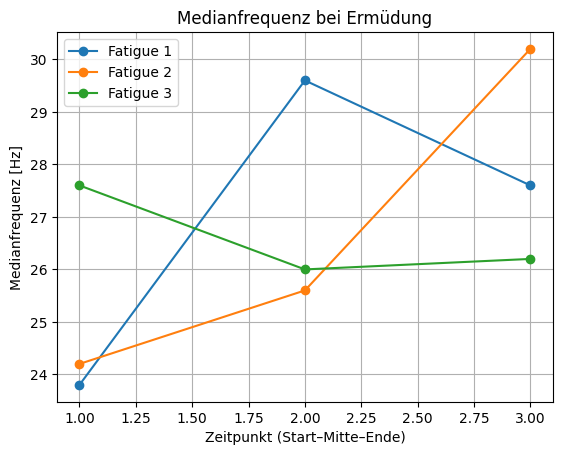

In [50]:

# Medianfrequenzen über Zeit
mf = np.array(median_freqs).reshape(3,3)

plt.figure()
for i in range(3):
    plt.plot([1,2,3], mf[i], 'o-', label=f'Fatigue {i+1}')

plt.xlabel("Zeitpunkt (Start–Mitte–Ende)")
plt.ylabel("Medianfrequenz [Hz]")
plt.title("Medianfrequenz bei Ermüdung")
plt.legend()
plt.grid()
plt.show()
